# King County Housing Sale Price Analysis

**Author:** Dan Lee

## Business Problem
A prominent YouTuber has hired us because she is planning to produce a series of videos on flipping houses. The process of flipping property is essentially purchasing some real estate, investing in it through construction or additions, and selling for a profit. Our client wants to know what features most determine home sale price, so she can give her viewers a guide on how to best invest in the properties they purchase/sell.


## Data Understanding
The dataset we are analyzing contains information about real estate in King County. This includes 21,597 entries spanning May 2014 - May 2015. We will use this data to create a multiple linear regression model in order to discover two features that affect home sale price.

## Data Preparation
In order to ensure clean data, we will explore the dataset for outliers, missing values, and multicollinearity.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
drop_cols = [
    'date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15', 'id'
]
df = df.drop(drop_cols, axis=1)

In [5]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   19221 non-null  float64
 7   condition    21597 non-null  int64  
 8   grade        21597 non-null  int64  
 9   yr_built     21597 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.6 MB


In [7]:
# Assume null values for column: waterfront means the property does not have a waterfront view
df = df.fillna(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   waterfront   21597 non-null  float64
 7   condition    21597 non-null  int64  
 8   grade        21597 non-null  int64  
 9   yr_built     21597 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.6 MB


In [9]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,3.409825,7.657915,1970.999676
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.650546,1.173200,29.375234
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1975.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,1997.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


In [10]:
df[df['bedrooms'] > 8]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
4092,599999.0,9,4.50,3830,6988,2.5,0.0,3,7,1938
4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,1908
6073,1280000.0,9,4.50,3650,5000,2.0,0.0,3,8,1915
8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,1996
8748,520000.0,11,3.00,3000,4960,2.0,0.0,3,7,1918
13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2008
15147,650000.0,10,2.00,3610,11914,2.0,0.0,4,7,1958
15856,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1947
16830,1400000.0,9,4.00,4620,5508,2.5,0.0,3,11,1915
18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1918


In [11]:
# Dropping the odd property with 33 bedrooms
df.drop(index=15856,inplace=True)

In [12]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04,1.494119,0.006761,3.409752,7.657946,1971.000787
std,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04,0.539685,0.081946,0.650471,1.173218,29.375460
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,3.000000,7.000000,1975.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04,2.000000,0.000000,4.000000,8.000000,1997.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


In [13]:
df[df['sqft_living'] > 8000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
1162,5110000.0,5,5.25,8010,45517,2.0,1.0,3,12,1999
3910,7060000.0,5,4.50,10040,37325,2.0,1.0,3,11,1940
4407,5570000.0,5,5.75,9200,35069,2.0,0.0,3,13,2001
7245,7700000.0,6,8.00,12050,27600,2.5,0.0,4,13,1910
8085,4670000.0,5,6.75,9640,13068,1.0,1.0,3,12,1983
9245,6890000.0,6,7.75,9890,31374,2.0,0.0,3,13,2001
12764,2280000.0,7,8.00,13540,307752,3.0,0.0,3,12,1999
14542,2890000.0,5,6.25,8670,64033,2.0,0.0,3,13,1965
18288,3300000.0,5,6.25,8020,21738,2.0,0.0,3,11,2001


In [14]:
df.isna().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

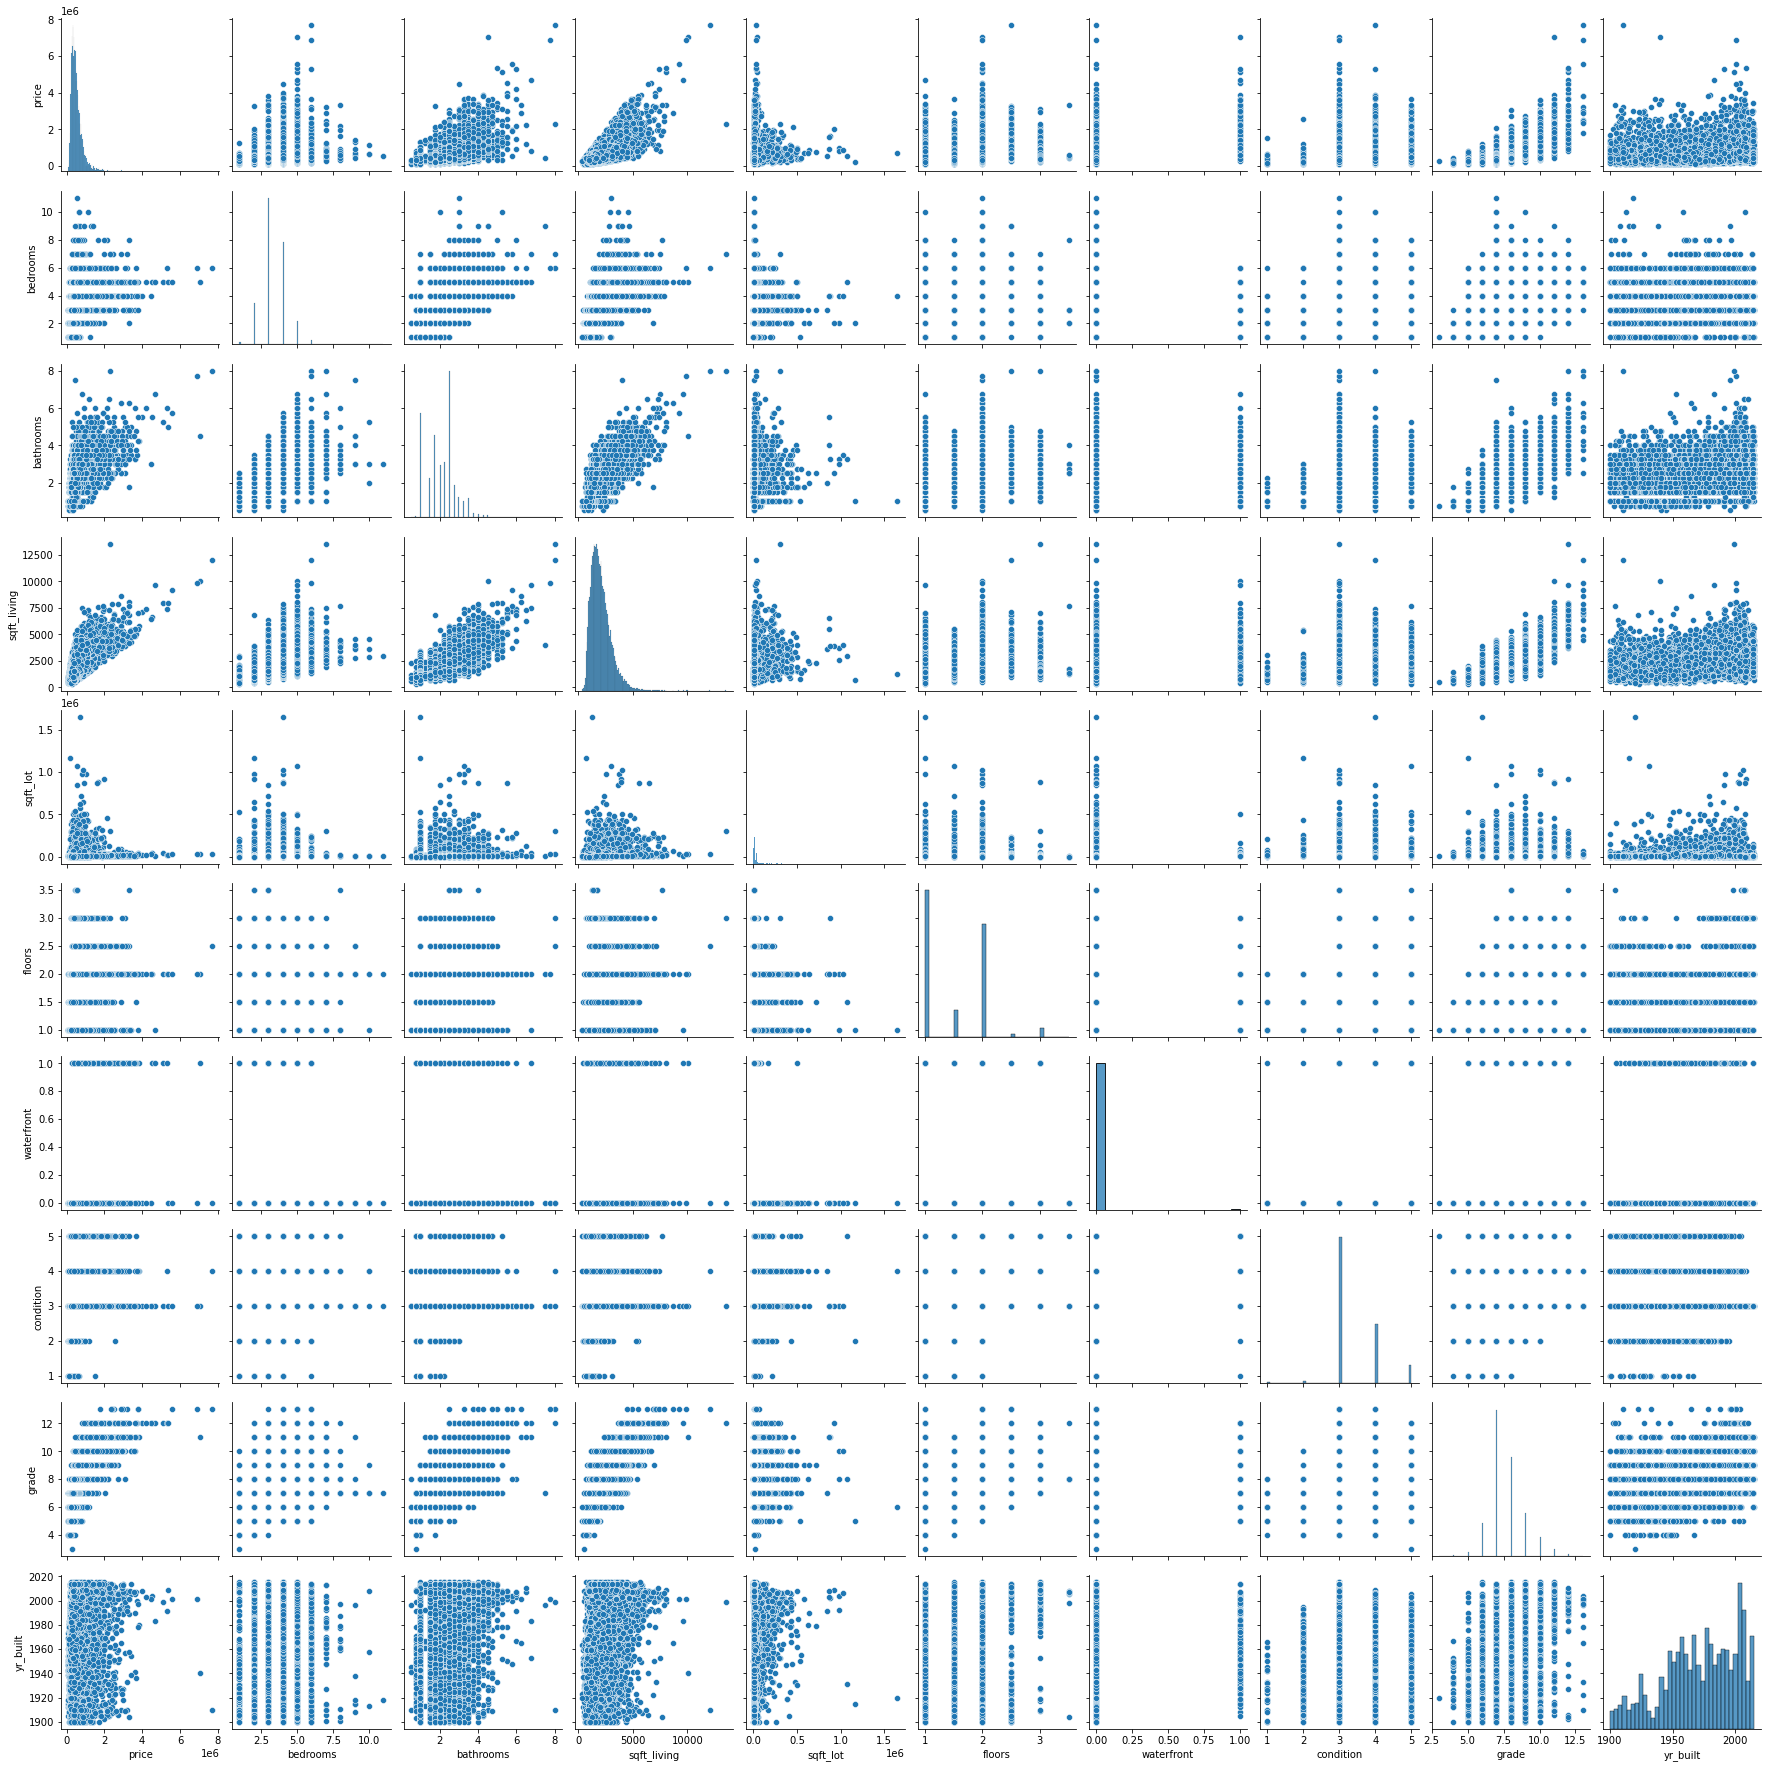

In [15]:
sns.pairplot(df)

In [16]:
# Possibly some multicollinearity between bed/bath and sqft_living. Will check this in modeling.

<AxesSubplot:>

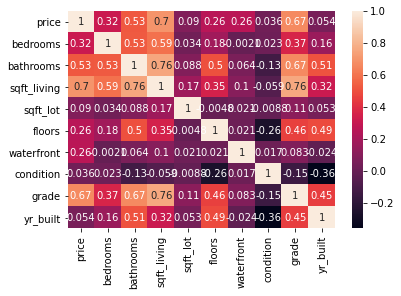

In [17]:
sns.heatmap(df.corr(), annot=True)

In [18]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

## Modeling
Here are the strategies we will attempt as we fine tune our baseline linear regression model:
1. Remove features based on coefficient values
2. One hot encode categorical data
3. Check for substantial interaction relationships between features

In [19]:
# First, create a baseline model

In [20]:
# Define X and y

used_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'yr_built']

X = df[used_cols]
y = df['price']

In [21]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [22]:
# Using a standard scaler
scaler = StandardScaler()

# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression Model

In [23]:
# Instantiate a linear regression model
lr = LinearRegression()

In [24]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'yr_built'],
      dtype='object')

In [26]:
lr.coef_

array([ -46383.31360808,   45524.25114741,  170317.06757107,
        -12500.43673523,    9477.74422744,   13599.38780936,
        156948.61215719, -119549.87371116])

In [27]:
lr.intercept_

542484.1496302438

In [28]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6221
MAE: 145780.8104
---
Testing Scores:
R2 Score: 0.6114
MAE: 144377.0921


In [29]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.613992
Test R2 Score: 0.628440
-----
Random Seed: 1
Train R2 Score: 0.618734
Test R2 Score: 0.618436
-----
Random Seed: 2
Train R2 Score: 0.622474
Test R2 Score: 0.610720
-----
Random Seed: 3
Train R2 Score: 0.623327
Test R2 Score: 0.608108
-----
Random Seed: 4
Train R2 Score: 0.615630
Test R2 Score: 0.624370
-----
Random Seed: 5
Train R2 Score: 0.618184
Test R2 Score: 0.619285
-----
Random Seed: 6
Train R2 Score: 0.624535
Test R2 Score: 0.606820
-----
Random Seed: 7
Train R2 Score: 0.620943
Test R2 Score: 0.613762
-----
Random Seed: 8
Train R2 Score: 0.620639
Test R2 Score: 0.614806
-----
Random Seed: 9
Train R2 Score: 0.619854
Test R2 Score: 0.616460
-----


We will try removing squarefoot lot, floors, and condition features since their coefficients have a lower absolute value than the others.

In [30]:
# Try less features: remove sqft_lot, floors, condition

In [31]:
# Define X and y

used_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'yr_built']

X = df[used_cols]
y = df['price']

In [32]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [33]:
# Using a standard scaler
scaler = StandardScaler()

# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Remove Features Regression Model

In [34]:
# Instantiate a linear regression model
lr = LinearRegression()

In [35]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [36]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'yr_built'], dtype='object')

In [37]:
lr.coef_

array([ -44770.61240734,   50953.01605576,  164780.76925863,
        159352.84347056, -122788.79276654])

In [38]:
lr.intercept_

542484.1496302438

In [39]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6195
MAE: 146412.9767
---
Testing Scores:
R2 Score: 0.6098
MAE: 144820.6720


In [40]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.611069
Test R2 Score: 0.628281
-----
Random Seed: 1
Train R2 Score: 0.616293
Test R2 Score: 0.616584
-----
Random Seed: 2
Train R2 Score: 0.620624
Test R2 Score: 0.607708
-----
Random Seed: 3
Train R2 Score: 0.621518
Test R2 Score: 0.604881
-----
Random Seed: 4
Train R2 Score: 0.613212
Test R2 Score: 0.622370
-----
Random Seed: 5
Train R2 Score: 0.615968
Test R2 Score: 0.617080
-----
Random Seed: 6
Train R2 Score: 0.622242
Test R2 Score: 0.604565
-----
Random Seed: 7
Train R2 Score: 0.617888
Test R2 Score: 0.613577
-----
Random Seed: 8
Train R2 Score: 0.618512
Test R2 Score: 0.612618
-----
Random Seed: 9
Train R2 Score: 0.617448
Test R2 Score: 0.614654
-----


In [41]:
# Less features used, virtually the same result

We will remove bedroom and bathroom features since they seem to have multicollinearity with sqf

In [42]:
# Remove bedrooms and bathrooms because of multicollinearity with sqft_living

In [43]:
# Define X and y

used_cols = ['sqft_living', 'grade', 'yr_built']

X = df[used_cols]
y = df['price']

In [44]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [45]:
# Using a standard scaler
scaler = StandardScaler()

# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Remove More Features Regression Model

In [46]:
# Instantiate a linear regression model
lr = LinearRegression()

In [47]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
X_train.columns

Index(['sqft_living', 'grade', 'yr_built'], dtype='object')

In [49]:
lr.coef_

array([ 162435.01934411,  173223.11138616, -109968.72107639])

In [50]:
lr.intercept_

542484.1496302438

In [51]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6069
MAE: 148994.4267
---
Testing Scores:
R2 Score: 0.5962
MAE: 147844.0295


In [52]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.597061
Test R2 Score: 0.617750
-----
Random Seed: 1
Train R2 Score: 0.601551
Test R2 Score: 0.607806
-----
Random Seed: 2
Train R2 Score: 0.608913
Test R2 Score: 0.592330
-----
Random Seed: 3
Train R2 Score: 0.607150
Test R2 Score: 0.594974
-----
Random Seed: 4
Train R2 Score: 0.599309
Test R2 Score: 0.611154
-----
Random Seed: 5
Train R2 Score: 0.604076
Test R2 Score: 0.602149
-----
Random Seed: 6
Train R2 Score: 0.611443
Test R2 Score: 0.588099
-----
Random Seed: 7
Train R2 Score: 0.603816
Test R2 Score: 0.602877
-----
Random Seed: 8
Train R2 Score: 0.606214
Test R2 Score: 0.598283
-----
Random Seed: 9
Train R2 Score: 0.604922
Test R2 Score: 0.600616
-----


In [53]:
# Again, less features used and virtually the same result

In [54]:
# Analyzing house prices based on the decade it was built in
df_yr_built = df.copy()

In [55]:
year = 1900

while year <= 2015:
    df_yr_built.loc[(df_yr_built['yr_built'] >= year)
                    & (df_yr_built['yr_built'] < (year + 10)),
                    'yr_built'] = year
    year += 10

In [56]:
df_yr_built.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1950
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1950
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1930
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1960
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1980


(0.0, 1000000.0)

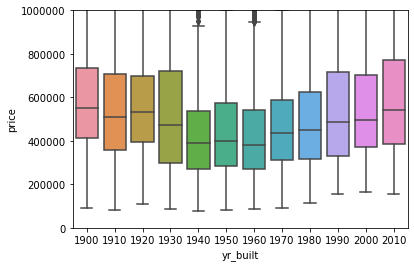

In [57]:
sns.boxplot(x='yr_built', y='price',
            data=df_yr_built).ticklabel_format(style='plain',
                                               axis='y',
                                               useOffset=False)
plt.ylim(0, 1000000)

<AxesSubplot:xlabel='yr_built', ylabel='Count'>

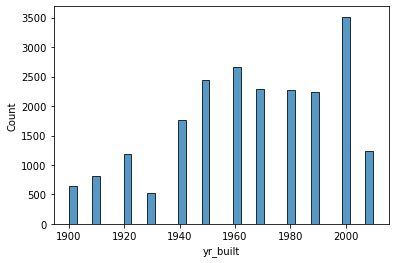

In [58]:
sns.histplot(x='yr_built', data=df_yr_built)

In [59]:
# Possibly a non-linear relationship, should consider running a polynomial model

In [60]:
# Analyzing house prices based on residential building grade

In [61]:
df_grade = df.copy()

<AxesSubplot:xlabel='grade', ylabel='Count'>

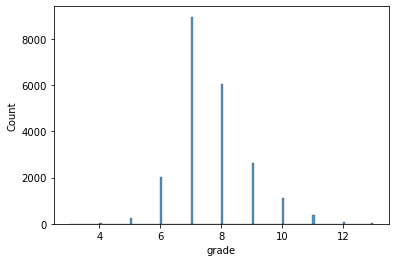

In [62]:
sns.histplot(x='grade', data=df_grade)

In [63]:
# We'll define "Average" as grades 7 and 8

In [64]:
df_grade.loc[df_grade['grade'] <= 6, 'grade_avg'] = 'Below Average'
df_grade.loc[(df_grade['grade'] >= 7) & (df_grade['grade'] <= 8),
             'grade_avg'] = 'Average'
df_grade.loc[df_grade['grade'] >= 9, 'grade_avg'] = 'Above Average'

In [65]:
df_grade.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,grade_avg
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,Average
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,Average
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,Below Average
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,Average
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,Average


In [66]:
df_grade['grade_avg'].value_counts()

Average          15038
Above Average     4250
Below Average     2308
Name: grade_avg, dtype: int64

Text(0.5, 1.0, 'Average Sale Price per Residential Building Grade')

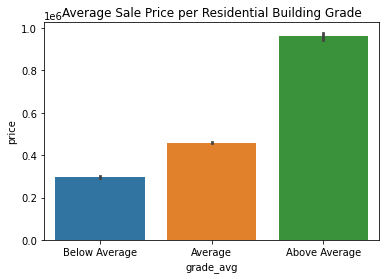

In [67]:
sns.barplot(x="grade_avg",
            y="price",
            data=df_grade,
            order=['Below Average', 'Average', 'Above Average'])
plt.title('Average Sale Price per Residential Building Grade')

In [68]:
df_sqft = df.copy()

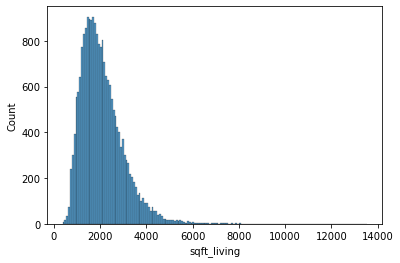

In [69]:
sns.histplot(x='sqft_living', data=df_sqft);

In [70]:
df_sqft['sqft_living'].max()

13540

In [71]:
# Dividing all properties into 1000 sq ft bins

sqft = 0

while sqft <= 8000:
    df_sqft.loc[(df_sqft['sqft_living'] >= sqft)
                & (df_sqft['sqft_living'] < (sqft + 1000)),
                'Square Foot Living Space'] = (sqft + 1000)
    sqft += 1000

df_sqft.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,Square Foot Living Space
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,2000.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,3000.0
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,1000.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,2000.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,2000.0


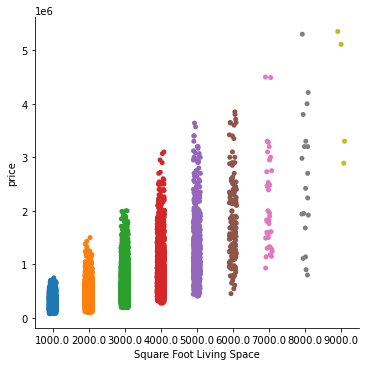

In [72]:
sns.catplot(x='Square Foot Living Space', y='price', data=df_sqft)

<AxesSubplot:xlabel='Square Foot Living Space', ylabel='price'>

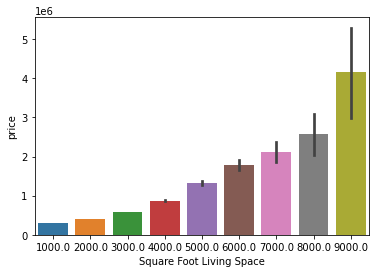

In [73]:
sns.barplot(x='Square Foot Living Space', y='price', data=df_sqft)

In [74]:
df_sqft.loc[df_sqft['Square Foot Living Space'] == 1000,
            'SQFT Living Space'] = 'Up to 1000'

In [75]:
df_sqft.loc[df_sqft['Square Foot Living Space'] == 2000,
            'SQFT Living Space'] = '1000-2000'
df_sqft.loc[df_sqft['Square Foot Living Space'] == 3000,
            'SQFT Living Space'] = '2000-3000'
df_sqft.loc[df_sqft['Square Foot Living Space'] == 4000,
            'SQFT Living Space'] = '3000-4000'
df_sqft.loc[df_sqft['Square Foot Living Space'] == 5000,
            'SQFT Living Space'] = '4000-5000'
df_sqft.loc[df_sqft['Square Foot Living Space'] == 6000,
            'SQFT Living Space'] = '5000-6000'
df_sqft.loc[df_sqft['Square Foot Living Space'] > 6000,
            'SQFT Living Space'] = 'Over 6000'

In [76]:
df_sqft.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,Square Foot Living Space,SQFT Living Space
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955,2000.0,1000-2000
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951,3000.0,2000-3000
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933,1000.0,Up to 1000
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965,2000.0,1000-2000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987,2000.0,1000-2000


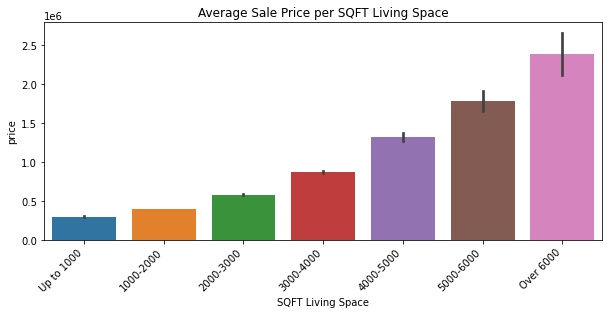

In [77]:
plt.figure(figsize=(10, 4))
sqft_plot = sns.barplot(x='SQFT Living Space',
                        y='price',
                        data=df_sqft,
                        order=[
                            'Up to 1000', '1000-2000', '2000-3000',
                            '3000-4000', '4000-5000', '5000-6000', 'Over 6000'
                        ])
sqft_plot.set_xticklabels(sqft_plot.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='right')
sqft_plot.set_title('Average Sale Price per SQFT Living Space')
plt.show()

<Figure size 720x288 with 0 Axes>

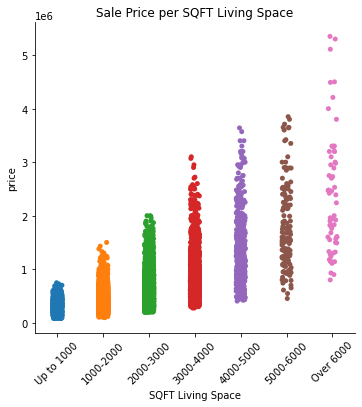

In [78]:
plt.figure(figsize=(10, 4))
sqft_plot = sns.catplot(x='SQFT Living Space',
                        y='price',
                        data=df_sqft,
                        order=[
                            'Up to 1000', '1000-2000', '2000-3000',
                            '3000-4000', '4000-5000', '5000-6000', 'Over 6000'
                        ])
plt.title('Sale Price per SQFT Living Space')
plt.xticks(rotation=45)
plt.show()

### Encode Categorical Data

In [79]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

In [80]:
# Explore waterfront
df['waterfront'].value_counts()

0.0    21450
1.0      146
Name: waterfront, dtype: int64

In [81]:
# Extremely skewed distribution, but worth trying to see if waterfront properties have an effect on price

In [82]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [83]:
cat_cols = ['waterfront']

In [84]:
used_cols = [*used_cols, *cat_cols]

In [85]:
used_cols

['sqft_living', 'grade', 'yr_built', 'waterfront']

In [86]:
X = df[used_cols]

In [87]:
X

,sqft_living,grade,yr_built,waterfront
0,1180,7,1955,0.0
1,2570,7,1951,0.0
2,770,6,1933,0.0
3,1960,7,1965,0.0
4,1680,8,1987,0.0
...,...,...,...,...
21592,1530,8,2009,0.0
21593,2310,8,2014,0.0
21594,1020,7,2009,0.0
21595,1600,8,2004,0.0


In [88]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [89]:
# Creating an encoder object
encoder = OneHotEncoder(categories='auto', drop='first')

# Creating an columntransformer object

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)

X_train_ohe = ct.transform(X_train)
X_test_ohe = ct.transform(X_test)

In [90]:
pd.DataFrame(X_train_ohe, columns= ct.get_feature_names()).head()

,ohe__x0_1.0,sqft_living,grade,yr_built
0,0.0,2270.0,8.0,1954.0
1,0.0,2360.0,8.0,2008.0
2,0.0,1678.0,7.0,1994.0
3,1.0,1550.0,6.0,1930.0
4,0.0,2770.0,8.0,1967.0


In [91]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_ohe)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

### Add Waterfront Regression Model

In [92]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

LinearRegression()

In [93]:
lr.coef_

array([  66815.78575942,  154762.5154394 ,  170944.99704043,
       -104619.64868751])

In [94]:
lr.intercept_

542484.1496302438

In [95]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6389
MAE: 144941.3861
---
Testing Scores:
R2 Score: 0.6227
MAE: 145451.6261


In [96]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.629788
Test R2 Score: 0.642362
-----
Random Seed: 1
Train R2 Score: 0.632243
Test R2 Score: 0.636882
-----
Random Seed: 2
Train R2 Score: 0.639936
Test R2 Score: 0.620932
-----
Random Seed: 3
Train R2 Score: 0.635497
Test R2 Score: 0.629254
-----
Random Seed: 4
Train R2 Score: 0.632108
Test R2 Score: 0.636436
-----
Random Seed: 5
Train R2 Score: 0.631769
Test R2 Score: 0.636322
-----
Random Seed: 6
Train R2 Score: 0.636032
Test R2 Score: 0.627995
-----
Random Seed: 7
Train R2 Score: 0.633023
Test R2 Score: 0.635192
-----
Random Seed: 8
Train R2 Score: 0.634206
Test R2 Score: 0.632694
-----
Random Seed: 9
Train R2 Score: 0.634848
Test R2 Score: 0.631400
-----


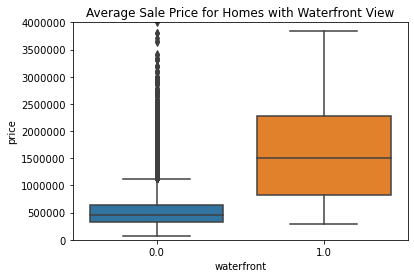

In [97]:
water_plot = sns.boxplot(x='waterfront', y='price', data=df).ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylim(0, 4000000)
plt.title('Average Sale Price for Homes with Waterfront View');

In [98]:
# Add interaction feature between condition and grade

In [99]:
X_interact = X.copy()

In [100]:
X_interact['condition_grade'] = df['condition'] * df['grade']

In [101]:
X_interact.drop(['grade'], axis=1, inplace=True)

In [102]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_interact, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [103]:
# Creating an encoder object
encoder = OneHotEncoder(categories='auto', drop='first')

# Creating an columntransformer object

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)

X_train_ohe = ct.transform(X_train)
X_test_ohe = ct.transform(X_test)

In [104]:
pd.DataFrame(X_train_ohe, columns=ct.get_feature_names()).head()

,ohe__x0_1.0,sqft_living,yr_built,condition_grade
0,0.0,2270.0,1954.0,40.0
1,0.0,2360.0,2008.0,24.0
2,0.0,1678.0,1994.0,21.0
3,1.0,1550.0,1930.0,18.0
4,0.0,2770.0,1967.0,24.0


In [105]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_ohe)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

### Condition/Grade Linear Regression Model

In [106]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

LinearRegression()

In [107]:
lr.coef_

array([ 68032.43251284, 237434.74901089, -53547.86006318,  67407.42908584])

In [108]:
lr.intercept_

542484.1496302439

In [109]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.5845
MAE: 159163.5410
---
Testing Scores:
R2 Score: 0.5707
MAE: 158815.0562


In [110]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_interact,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.579860
Test R2 Score: 0.580607
-----
Random Seed: 1
Train R2 Score: 0.579588
Test R2 Score: 0.581301
-----
Random Seed: 2
Train R2 Score: 0.580086
Test R2 Score: 0.580162
-----
Random Seed: 3
Train R2 Score: 0.583529
Test R2 Score: 0.572160
-----
Random Seed: 4
Train R2 Score: 0.578077
Test R2 Score: 0.583728
-----
Random Seed: 5
Train R2 Score: 0.574224
Test R2 Score: 0.589982
-----
Random Seed: 6
Train R2 Score: 0.577435
Test R2 Score: 0.583664
-----
Random Seed: 7
Train R2 Score: 0.579597
Test R2 Score: 0.581259
-----
Random Seed: 8
Train R2 Score: 0.579744
Test R2 Score: 0.580835
-----
Random Seed: 9
Train R2 Score: 0.580384
Test R2 Score: 0.579520
-----


In [111]:
# Ditch this interaction

In [112]:
# Add interaction feature between sqft_living and grade

In [113]:
X_interact = X.copy()

In [114]:
X_interact['sqft_living_grade'] = df['sqft_living'] * df['grade']

In [115]:
X_interact.drop(['grade'], axis=1, inplace=True)
X_interact.drop(['sqft_living'], axis=1, inplace=True)

In [116]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_interact,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [117]:
# Creating an encoder object
encoder = OneHotEncoder(categories='auto', drop='first')

# Creating an columntransformer object

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)

X_train_ohe = ct.transform(X_train)
X_test_ohe = ct.transform(X_test)

In [118]:
pd.DataFrame(X_train_ohe, columns= ct.get_feature_names()).head()

,ohe__x0_1.0,yr_built,sqft_living_grade
0,0.0,1954.0,18160.0
1,0.0,2008.0,18880.0
2,0.0,1994.0,11746.0
3,1.0,1930.0,9300.0
4,0.0,1967.0,22160.0


In [119]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train_ohe)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

### Sqft_living/Grade Regression Model

In [120]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

LinearRegression()

In [121]:
lr.coef_

array([ 63395.97262196, -79828.55801811, 298806.427171  ])

In [122]:
lr.intercept_

542484.1496302438

In [123]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6466
MAE: 147371.9446
---
Testing Scores:
R2 Score: 0.6399
MAE: 146994.7780


In [124]:
for n in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_interact,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=n)  # <--
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    y_train_pred = lr.predict(X_train_scaled)
    y_test_pred = lr.predict(X_test_scaled)

    print(f"Random Seed: {n}")
    print(f"Train R2 Score: {r2_score(y_train, y_train_pred):4f}")
    print(f"Test R2 Score: {r2_score(y_test, y_test_pred):4f}")
    print("-----")

Random Seed: 0
Train R2 Score: 0.646100
Test R2 Score: 0.640629
-----
Random Seed: 1
Train R2 Score: 0.646501
Test R2 Score: 0.639817
-----
Random Seed: 2
Train R2 Score: 0.640305
Test R2 Score: 0.652344
-----
Random Seed: 3
Train R2 Score: 0.649036
Test R2 Score: 0.634084
-----
Random Seed: 4
Train R2 Score: 0.643463
Test R2 Score: 0.646147
-----
Random Seed: 5
Train R2 Score: 0.638681
Test R2 Score: 0.654483
-----
Random Seed: 6
Train R2 Score: 0.633431
Test R2 Score: 0.662813
-----
Random Seed: 7
Train R2 Score: 0.646281
Test R2 Score: 0.640445
-----
Random Seed: 8
Train R2 Score: 0.642548
Test R2 Score: 0.648058
-----
Random Seed: 9
Train R2 Score: 0.647176
Test R2 Score: 0.638850
-----


In [125]:
# Succesful interaction

In [126]:
df_grade['sqft_living_grade'] = df_grade['sqft_living'] * df_grade['grade']
df_grade.drop(['grade'], axis=1, inplace=True)
df_grade.drop(['sqft_living'], axis=1, inplace=True)

Text(0.5, 1.0, 'Sale Price per Building Grade * Square Foot Living Space')

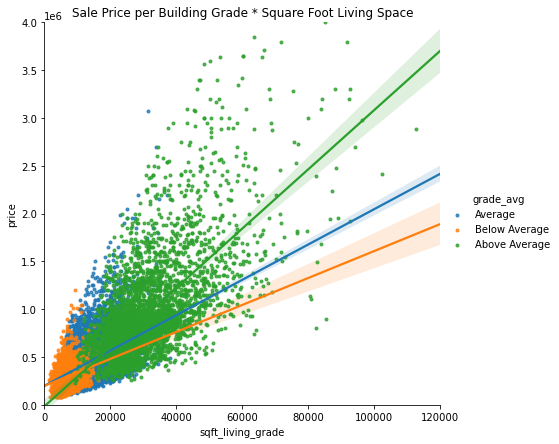

In [127]:
sns.lmplot(x="sqft_living_grade",
           y='price',
           hue='grade_avg',
           height=6,
           truncate=False,
           markers=".",
           data=df_grade).set(ylim=(0, 4000000), xlim=(0, 120000))
plt.title('Sale Price per Building Grade * Square Foot Living Space')

In [128]:
# There is clearly a strong interaction relationship between 
# sqft living space and building grade and their affect on sale price

In [129]:
# Add polynomial

In [130]:
from sklearn.preprocessing import PolynomialFeatures

In [131]:
X = X_interact.copy()

In [132]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

In [133]:
# Creating an encoder object
encoder = OneHotEncoder(categories='auto', drop='first')

# Creating an columntransformer object

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)

X_train_ohe = ct.transform(X_train)
X_test_ohe = ct.transform(X_test)

In [134]:
pd.DataFrame(X_train_ohe, columns= ct.get_feature_names()).head()

,ohe__x0_1.0,yr_built,sqft_living_grade
0,0.0,1954.0,18160.0
1,0.0,2008.0,18880.0
2,0.0,1994.0,11746.0
3,1.0,1930.0,9300.0
4,0.0,1967.0,22160.0


In [135]:
poly = PolynomialFeatures(degree=4, interaction_only=False)

In [136]:
poly.fit(X_train_ohe)

PolynomialFeatures(degree=4)

In [137]:
X_train_poly = poly.transform(X_train_ohe)
X_test_poly = poly.transform(X_test_ohe)

In [138]:
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names())
X_train_poly.head()

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2,...,x0^2 x2^2,x0 x1^3,x0 x1^2 x2,x0 x1 x2^2,x0 x2^3,x1^4,x1^3 x2,x1^2 x2^2,x1 x2^3,x2^4
0,1.0,0.0,1954.0,18160.0,0.0,0.0,0.0,3818116.0,35484640.0,329785600.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.457801e+13,1.354845e+14,1.259160e+15,1.170232e+16,1.087585e+17
1,1.0,0.0,2008.0,18880.0,0.0,0.0,0.0,4032064.0,37911040.0,356454400.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.625754e+13,1.528597e+14,1.437247e+15,1.351356e+16,1.270597e+17
2,1.0,0.0,1994.0,11746.0,0.0,0.0,0.0,3976036.0,23421524.0,137968516.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.580886e+13,9.312482e+13,5.485678e+14,3.231433e+15,1.903531e+16
3,1.0,1.0,1930.0,9300.0,1.0,1930.0,9300.0,3724900.0,17949000.0,86490000.0,...,86490000.0,7.189057e+09,3.464157e+10,1.669257e+11,8.043570e+11,1.387488e+13,6.685823e+13,3.221666e+14,1.552409e+15,7.480520e+15
4,1.0,0.0,1967.0,22160.0,0.0,0.0,0.0,3869089.0,43588720.0,491065600.0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.496985e+13,1.686486e+14,1.899977e+15,2.140492e+16,2.411454e+17


In [139]:
# Still need to scale
scaler = StandardScaler()

scaler.fit(X_train_poly)

X_train_poly_sc = scaler.transform(X_train_poly)
X_test_poly_sc = scaler.transform(X_test_poly)

### Polynomial Regression Model

In [140]:
lr = LinearRegression()

lr.fit(X_train_poly_sc, y_train)

LinearRegression()

In [141]:
lr.coef_

array([-2.02286183e-01, -4.16285647e+16,  4.17771545e+09, -6.99912840e+09,
        1.46402552e+16,  3.08355643e+15,  1.88463970e+17, -1.26469852e+10,
        2.12224966e+10,  2.14862088e+08,  1.32474520e+16, -1.44515132e+15,
       -9.43110766e+16,  1.02113400e+14,  6.69290265e+12,  3.70635429e+14,
        1.27546427e+10, -2.14527349e+10, -4.38533861e+08,  1.62047250e+06,
        1.37408539e+16, -1.63839458e+15, -9.41528934e+16, -1.02124013e+14,
       -6.69273685e+12, -3.70635428e+14,  3.56762273e+09, -8.27084265e+07,
       -1.00711575e+06,  8.82370000e+04, -4.28531927e+09,  7.22908546e+09,
        2.24214319e+08, -1.97126700e+06,  1.08995000e+05])

In [142]:
lr.intercept_

542484.147965386

In [143]:
# Predict and evaluate
y_train_pred = lr.predict(X_train_poly_sc)
y_test_pred = lr.predict(X_test_poly_sc)

print("Training Scores:")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print("---")
print("Testing Scores:")
print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Scores:
R2 Score: 0.6902
MAE: 137663.2167
---
Testing Scores:
R2 Score: 0.6838
MAE: 138325.1017


In [144]:
n = 1

while n < 9:

    X = X_interact.copy()

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.33,
                                                        random_state=42)

    # Creating an encoder object
    encoder = OneHotEncoder(categories='auto', drop='first')

    # Creating an columntransformer object

    ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                           remainder='passthrough')

    ct.fit(X_train)

    X_train_ohe = ct.transform(X_train)
    X_test_ohe = ct.transform(X_test)

    pd.DataFrame(X_train_ohe, columns=ct.get_feature_names()).head()

    poly = PolynomialFeatures(degree=n, interaction_only=False)

    poly.fit(X_train_ohe)

    X_train_poly = poly.transform(X_train_ohe)
    X_test_poly = poly.transform(X_test_ohe)

    X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names())
    X_train_poly.head()

    # Still need to scale
    scaler = StandardScaler()

    scaler.fit(X_train_poly)

    X_train_poly_sc = scaler.transform(X_train_poly)
    X_test_poly_sc = scaler.transform(X_test_poly)

    # 4th Linear Regression Model

    lr = LinearRegression()

    lr.fit(X_train_poly_sc, y_train)

    lr.coef_

    lr.intercept_

    # Predict and evaluate
    y_train_pred = lr.predict(X_train_poly_sc)
    y_test_pred = lr.predict(X_test_poly_sc)

    print("Polynomial Power {} Training Scores:".format(n))
    print(f"R2 Score: {r2_score(y_train, y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
    print("---")
    print("Testing Scores:")
    print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    print("\n")

    n += 1

Polynomial Power 1 Training Scores:
R2 Score: 0.6466
MAE: 147371.9446
---
Testing Scores:
R2 Score: 0.6399
MAE: 146994.7780


Polynomial Power 2 Training Scores:
R2 Score: 0.6700
MAE: 140568.1545
---
Testing Scores:
R2 Score: 0.6740
MAE: 140622.9850


Polynomial Power 3 Training Scores:
R2 Score: 0.6830
MAE: 138387.8345
---
Testing Scores:
R2 Score: 0.6763
MAE: 139478.4004


Polynomial Power 4 Training Scores:
R2 Score: 0.6902
MAE: 137663.2167
---
Testing Scores:
R2 Score: 0.6838
MAE: 138325.1017


Polynomial Power 5 Training Scores:
R2 Score: 0.6966
MAE: 137380.8384
---
Testing Scores:
R2 Score: 0.1369
MAE: 141495.6295


Polynomial Power 6 Training Scores:
R2 Score: 0.7014
MAE: 136436.4271
---
Testing Scores:
R2 Score: -6.3257
MAE: 149299.1418


Polynomial Power 7 Training Scores:
R2 Score: 0.7030
MAE: 136424.2706
---
Testing Scores:
R2 Score: -128.0606
MAE: 187431.5009


Polynomial Power 8 Training Scores:
R2 Score: 0.7063
MAE: 135857.0744
---
Testing Scores:
R2 Score: -16279.7141
MA

## Evaluation
After multiple iterations on our model, the resulting findings are:
1. Square Foot Living Space & Residential Building Grade have the strongest relationship with home sale price
2. Waterfront view has a moderate affect on sale price, and is a worthy factor to consider

### Recommendations
A house flipper will want to keep the following in mind when allocating their resources towards home improvement:
1. Increase living area square footage - Renovate basement and attic spaces. Add extensions to the home. Build additional living space above the garage
2. Focus on quality of materials and finishes during construction - This includes kitchen countertops, floors, cabinetry design, lighting fixtures, luxury features
3. Keep an eye out for homes with a waterfront view